In [18]:
import time

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import scipy.stats
import statsmodels.api as sm

from statsmodels.nonparametric.smoothers_lowess import lowess

sns.set(style="white")
pd.set_option('display.max_columns', None)
%matplotlib inline

In [4]:
precinct_data_2018 = gpd.read_file("../data/processed/tidy/precinct_data_2018.geojson")
precinct_data_2016 = gpd.read_file("../data/processed/tidy/precinct_data_2016.geojson")

In [5]:
precinct_data_2018.iloc[:,8:81] = precinct_data_2018.iloc[:,8:81].round().apply(lambda x: x.astype(int))
precinct_data_2018.iloc[:,81:84] = precinct_data_2018.iloc[:,81:84].apply(pd.to_timedelta)

In [6]:
precinct_data_2016.head()

,countyfp,countyname,countynum,vtdst3,vtdstlong,cd115fp,sldust,sldlst,population,male,female,male under 18,male 18-29,male 30-49,male 50-64,male 65 plus,female under 18,female 18-29,female 30-49,female 50-64,female 65 plus,white,aa,aian,asian,nhopi,other,two+,male no hs,male some hs,male hs diploma,male some college,male bachelors,male masters,male doctorate,female no hs,female some hs,female hs diploma,female some college,female bachelors,female masters,female doctorate,family,married,other family,nonfamily,houses,occupied,vacant,owner-occupied,renter-occupied,less than 15k,15k-30k,30k-60k,60k-100k,100k-150k,more than 150k,less than 150k,150k-200k,200k-250k,250k-300k,300k-400k,more than 400k,female rv_active,male rv_active,unknown rv_active,female rv_inactive,male rv_inactive,unknown rv_inactive,female rv_18-29,male rv_18-29,unknown rv_18-29,female rv_30-49,male rv_30-49,unknown rv_30-49,female rv_50-64,male rv_50-64,unknown rv_50-64,female rv_over 65,male rv_over 65,unknown rv_over 65,female rv_mean_reg_time,male rv_mean_reg_time,unknown rv_mean_reg_time,female rv_acn,male rv_acn,unknown rv_acn,female rv_dem,male rv_dem,unknown rv_dem,female rv_grn,male rv_grn,unknown rv_grn,female rv_lbr,male rv_lbr,unknown rv_lbr,female rv_rep,male rv_rep,unknown rv_rep,female rv_uaf,male rv_uaf,unknown rv_uaf,female rv_uni,male rv_uni,unknown rv_uni,pres dem,pres grn,pres lib,pres rep,pres unf,state_rep dem,state_rep rep,us_rep dem,us_rep lib,us_rep rep,us_senate dem,us_senate grn,us_senate lib,us_senate rep,us_senate unf,state_rep unf,state_senate dem,state_senate rep,state_rep lib,state_senate lib,us_rep unf,us_rep grn,state_rep grn,geometry
0,001,Adams,01,001,7213201001,7,21,32,2426.200277,1290.547749,1135.652527,362.917081,314.228681,216.819167,273.350701,123.232119,352.082500,182.008750,223.781250,252.516407,125.263620,2175.599914,32.821250,43.761667,47.740000,0.0,66.602446,59.675000,0.000000,53.707500,388.708898,261.519613,122.333750,13.897227,0.0,9.945833,23.870000,224.685392,394.805325,42.740143,22.875417,0.0,574.759091,411.193561,163.565530,271.210606,904.204167,845.969697,58.234470,542.525758,303.443939,45.634091,69.164394,121.029545,193.231061,247.558333,160.423864,183.528409,194.979924,60.514773,78.919318,13.766667,10.816667,714,686,36,148,153,5,193,199,27,296,297,10,164,149,3,167,143,1,3796 days 01:35:13.225057984,3433 days 05:50:07.866507776,915 days 05:51:13.170731712,4,3,0,439,331,18,1,3,0,16,16,0,122,103,4,279,382,19,1,1,0,708,23,54,240,7,676,271,682,78,236,655,19,46,237,6,0,776,8,0,0,0,0,0,"POLYGON Z ((-105.05325 39.79106 0.00000, -105...."
1,001,Adams,01,002,7213201002,7,21,32,7311.258294,3833.719406,3477.538889,965.406793,854.224745,696.721465,934.466551,382.899853,775.263653,649.356325,863.276137,820.398376,369.244398,6728.660555,289.885996,7.966221,0.000000,0.0,107.007576,177.737947,151.006752,85.063236,855.815885,937.426461,413.977539,152.785795,0.0,48.335287,30.139335,889.819183,779.338726,508.507293,241.746958,0.0,1947.496070,1575.975545,371.520524,537.852597,2616.350714,2485.348667,131.002048,2023.020269,462.328398,200.829041,210.056762,204.738016,190.610477,605.772177,660.219838,316.806440,376.291051,160.986693,658.998152,355.015608,154.922324,756,690,37,88,118,1,136,125,23,327,293,11,174,193,0,158,150,4,4538 days 13:08:14.786729856,4113 days 02:33:16.039603968,873 days 02:31:34.736842112,1,3,0,482,357,9,2,3,0,4,10,0,107,133,3,247,302,26,1,0,0,776,17,52,291,6,774,295,771,63,282,730,22,43,280,6,0,854,5,0,0,0,0,0,"POLYGON Z ((-105.02521 39.80072 0.00000, -105...."
2,001,Adams,01,003,7213201003,7,21,32,935.908309,416.612291,519.296017,123.736077,107.116185,91.636507,65.104555,29.018967,191.831246,122.724096,89.508772,78.128545,37.103358,666.141995,57.474771,0.000000,10.115560,0.0,140.901255,61.274728,60.213297,34.146156,96.480360,49.976183,3.228082,0.243056,0.0,56.546533,67.151963,76.602565,66.272691,10.887204,2.750380,0.0,181.363563,79.936251,101.427312,55.853904,260.489235,237.217468,23.271768,94.139224,143.07824

# Questions

## What is the distribution of populations in each precinct

In [7]:
data = precinct_data_2016.copy()

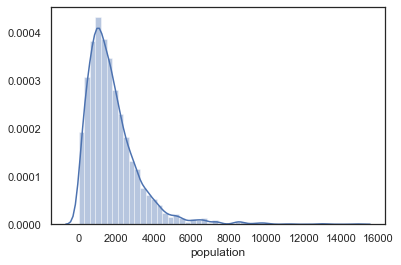

In [19]:
sns.distplot(data.population)

# 2D Correlations

What do I want to see correlations between?
- Demographics
    - Area
    - Age by gender
    - Gender pop
    - income
    - home value
    - fraction white
    - education by gender
    - frac family homes
    - frac occupied
    - frac owner occupied
    - frac active registered/potential
    - frac registered dem / voting dem
    - frac registers rep / voting rep
    - frac registered 3rd party / voting 3rd party

- results for pres, us senate
    - fraction voting dem
    - fraction voting rep
    - fraction voting third party
    - dem, rep frac

- results for us congress BY DISTRICT
    - fraction voting dem
    - fraction voting rep
    - fraction voting third party

In [9]:
data = pd.DataFrame()

infos = ['countyfp', 'countyname', 'countynum', 'vtdst3']
for info in infos:
    data[info] = precinct_data_2016[info]

data["area"] = (precinct_data_2016['geometry'].to_crs({'init': 'epsg:3395'})
                                .map(lambda p: p.area / 10**6))
data["area_rank"] = np.argsort(data.area.values)

data["population"] = precinct_data_2016.population

income_vars = [('less than 15k', 8), ('15k-30k', 23), ('30k-60k', 45), ('60k-100k', 80), ('100k-150k', 125), ('more than 150k', 200)]
income_names = [name for name, _ in income_vars]
income_med = [income for _, income in income_vars]
data["income"] = ((precinct_data_2016[income_names]*income_med).sum(axis=1)/
                  (precinct_data_2016[income_names]).sum(axis=1))

home_names = ['less than 150k', '150k-200k', '200k-250k', '250k-300k', '300k-400k', 'more than 400k']
home_med = [80, 175, 225, 275, 350, 750]
data["home_val"] = ((precinct_data_2016[home_names]*home_med).sum(axis=1)/
                  (precinct_data_2016[home_names]).sum(axis=1))

data["frac_white"] = precinct_data_2016.white/precinct_data_2016.population

data["male_college"] = (precinct_data_2016[["male bachelors", "male masters", "male doctorate"]].sum(axis=1) /
                        precinct_data_2016["male"])
data["female_college"] = (precinct_data_2016[["female bachelors", "female masters", "female doctorate"]].sum(axis=1) /
                        precinct_data_2016["female"])

data["frac_family"] = precinct_data_2016.family/precinct_data_2016.houses
data["frac_occupied"] = precinct_data_2016.occupied/precinct_data_2016.houses
data["frac_renter"] = precinct_data_2016["renter-occupied"]/precinct_data_2016.houses

In [10]:
data["frac_male_reg_male_pop"] = precinct_data_2016["male rv_active"]/precinct_data_2016.male
data["frac_female_reg_female_pop"] = precinct_data_2016["female rv_active"]/precinct_data_2016.female

data["frac_dem_pres_pop"] = precinct_data_2016["pres dem"]/precinct_data_2016.population
data["frac_rep_pres_pop"] = precinct_data_2016["pres rep"]/precinct_data_2016.population
data["frac_dem_senate_pop"] = precinct_data_2016["us_senate dem"]/precinct_data_2016.population
data["frac_rep_senate_pop"] = precinct_data_2016["us_senate rep"]/precinct_data_2016.population

total_reg = ['female rv_active', 'male rv_active', 'unknown rv_active', 'female rv_inactive', 'male rv_inactive', 'unknown rv_inactive']
total_vote = ['pres dem', 'pres grn', 'pres lib', 'pres rep', 'pres unf']
data["frac_reg_pop"] = precinct_data_2016[total_reg].sum(axis=1)/precinct_data_2016.population
data["frac_vote_pop"] = precinct_data_2016[total_vote].sum(axis=1)/precinct_data_2016.population
data["frac_vote_reg"] = precinct_data_2016[total_reg].sum(axis=1)/precinct_data_2016[total_vote].sum(axis=1)

data["frac_dem_pres_dem_reg"] = (precinct_data_2016["pres dem"]
                              / (precinct_data_2016["female rv_dem"]+precinct_data_2016["male rv_dem"]))
data["frac_rep_pres_dem_rep"] = (precinct_data_2016["pres rep"]
                              / (precinct_data_2016["female rv_rep"]+precinct_data_2016["male rv_rep"]))

data["frac_dem_senate_dem_reg"] = (precinct_data_2016["us_senate dem"]
                              / (precinct_data_2016["female rv_dem"]+precinct_data_2016["male rv_dem"]))
data["frac_rep_senate_rep_reg"] = (precinct_data_2016["us_senate rep"]
                              / (precinct_data_2016["female rv_rep"]+precinct_data_2016["male rv_rep"]))

data["dem_lean_pres"] = ((precinct_data_2016['pres dem'] - precinct_data_2016['pres rep'])
                         / (precinct_data_2016['pres dem'] + precinct_data_2016['pres rep']))

In [11]:
data.head()

,countyfp,countyname,countynum,vtdst3,area,area_rank,population,income,home_val,frac_white,male_college,female_college,frac_family,frac_occupied,frac_renter,frac_male_reg_male_pop,frac_female_reg_female_pop,frac_dem_pres_pop,frac_rep_pres_pop,frac_dem_senate_pop,frac_rep_senate_pop,frac_reg_pop,frac_vote_pop,frac_vote_reg,frac_dem_pres_dem_reg,frac_rep_pres_dem_rep,frac_dem_senate_dem_reg,frac_rep_senate_rep_reg,dem_lean_pres
0,001,Adams,01,001,3.418291,576,2426.200277,102.611704,178.891468,0.896711,0.105561,0.057778,0.635652,0.935596,0.335592,0.531557,0.628713,0.291814,0.098920,0.269969,0.097684,0.717995,0.425356,1.687984,0.919481,1.066667,0.850649,1.053333,0.493671
1,001,Adams,01,002,6.890596,1045,7311.258294,115.173461,271.420490,0.920315,0.147836,0.215743,0.744356,0.949929,0.176707,0.179982,0.217395,0.106138,0.039802,0.099846,0.038297,0.231150,0.156197,1.479860,0.924911,1.212500,0.870083,1.166667,0.454545
2,001,Adams,01,003,10.377840,543,935.908309,63.743753,122.718981,0.711760,0.008332,0.026262,0.696242,0.910661,0.549267,1.298569,1.088011,0.690239,0.263915,0.667800,0.271394,1.264013,1.044974,1.209611,1.276680,1.210784,1.235178,1.245098,0.446809
3,001,Adams,01,004,1.416992,1043,2119.970919,57.025829,121.016903,0.635809,0.006563,0.027046,0.671953,0.937120,0.657640,0.426139,0.380933,0.177361,0.106134,0.181606,0.089152,0.473120,0.301891,1.567187,0.812095,1.654412,0.831533,1.389706,0.251248
4,001,Adams,01,005,1.829473,1152,3841.243553,104.298147,206.948880,0.807216,0.202700,0.222759,0.752496,1.000000,0.254616,0.393327,0.406119,0.213473,0.083827,0.209828,0.076538,0.450635,0.313700,1.436515,0.949074,1.406114,0.932870,1.283843,0.436077


In [12]:
keepers = ['population', 'male', 'female']
keepers_norm = ['male 18-29', 'male 30-49', 'male 50-64',
                'male 65 plus', 'female 18-29', 'female 30-49',
                'female 50-64', 'female 65 plus']
for keep in keepers:
    data[keep] = precinct_data_2016[keep]
for keep in keepers_norm:
    data[keep] = precinct_data_2016[keep]/precinct_data_2016.population

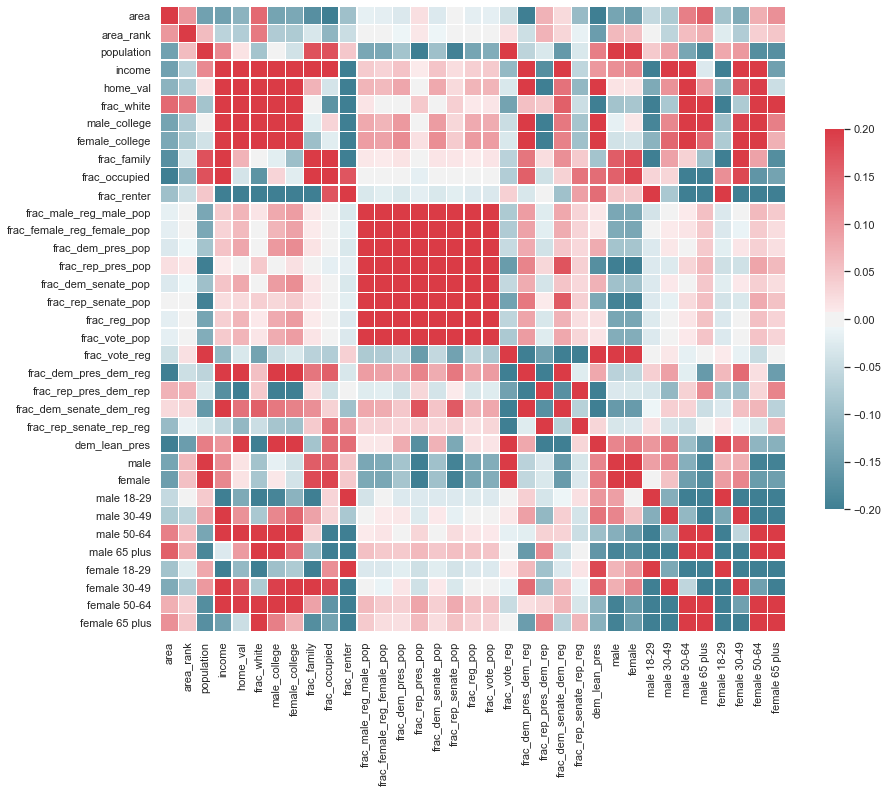

In [27]:
corr_data = data.iloc[:, 4:].corr()

f, ax = plt.subplots(figsize=(14, 14))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_data, cmap=cmap, vmax=.2, vmin=-.2, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .5})

This is awesome. This gives me 5 areas I would like to explore in more detail:
1. 00-10 x 00-10; the non-age demographics
2. 11-24 x 11-24; the purely voting registration and results statistics
3. 25-33 x 25-33; the sex by age demographics
4. 25-33 x 00-10; the sex by age with other demographics
5. 11-24 x 00-10; voting patterns by non age and sex demographics

In [41]:
def find_vars_from_numbers(df, nums):
    nums = [str(num).zfill(2) for num in nums]
    print(nums)
    vals = []
    for num in nums:
        for col in df.columns.values:
            if num == col[:2]:
                vals.append(col)
    return vals

def find_vars_from_numbers2(df, nums):
    new_nums = [str(num).zfill(2) for num in nums]
    cols = df.iloc[:,nums[0]:nums[-1]+1]
    return [col for num, col in zip(new_nums, cols)]

def filter_sub_corr(df, target1, target2):
    def selection_func(var1, var2):
        if var1 in target1 and var2 in target2:
            return True
        else:
            return False
        
    return df[df[['variable','variable2']].apply(lambda x: selection_func(*x), axis=1)]

In [48]:
non_age = data.iloc[:, 3:11]
voting = data.iloc[:, 11:25]
sex_by_age = data.iloc[:, 27:35]

In [54]:
corr_data.iloc[3:11, 11:25]

,frac_male_reg_male_pop,frac_female_reg_female_pop,frac_dem_pres_pop,frac_rep_pres_pop,frac_dem_senate_pop,frac_rep_senate_pop,frac_reg_pop,frac_vote_pop,frac_vote_reg,frac_dem_pres_dem_reg,frac_rep_pres_dem_rep,frac_dem_senate_dem_reg,frac_rep_senate_rep_reg,dem_lean_pres
income,0.040824,0.034293,0.051363,0.007930,0.048828,0.022805,0.038506,0.042296,-0.105558,0.332034,-0.173558,0.227384,-0.057972,0.098076
home_val,0.065767,0.059617,0.082153,0.004996,0.079152,0.025044,0.067010,0.065839,-0.030216,0.292338,-0.275833,0.138497,-0.106560,0.314178
frac_white,0.015101,0.004112,0.001655,0.044641,0.002719,0.037796,0.010182,0.012862,-0.141581,0.053467,0.044684,0.158083,-0.045551,-0.218919
male_college,0.078531,0.065865,0.095384,0.006012,0.092725,0.028511,0.077234,0.076198,-0.047177,0.294871,-0.288498,0.132082,-0.086302,0.335932
female_college,0.091172,0.086916,0.110671,0.019258,0.108364,0.041239,0.094013,0.091742,-0.031210,0.278372,-0.293130,0.120556,-0.093368,0.354533
frac_family,0.012431,0.008555,0.016554,0.007055,0.015165,0.013103,0.009248,0.014569,-0.064491,0.135303,0.022617,0.106656,0.043117,-0.088543
frac_occupied,-0.000160,-0.004621,0.007190,-0.018710,0.004752,-0.007645,-0.003685,0.001070,-0.072620,0.158338,-0.041074,0.034560,0.137439,0.144742
frac_renter,-0.030559,-0.021300,-0.030486,-0.019257,-0.030980,-0.020690,-0.027349,-0.028129,0.037382,-0.032437,0.002035,-0.093681,0.087972,0.144055


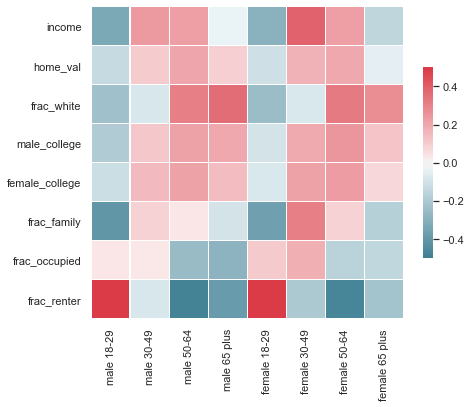

In [59]:
sub_data = corr_data.iloc[3:11, 27:35]
f, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(sub_data, cmap=cmap, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .5})

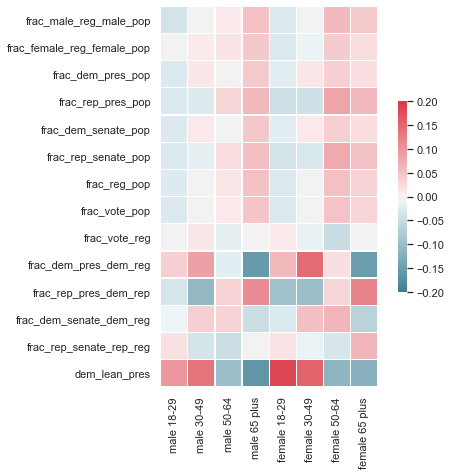

In [61]:
sub_data = corr_data.iloc[11:25, 27:35]
f, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(sub_data, cmap=cmap, vmax=.2, vmin=-.2, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .5})

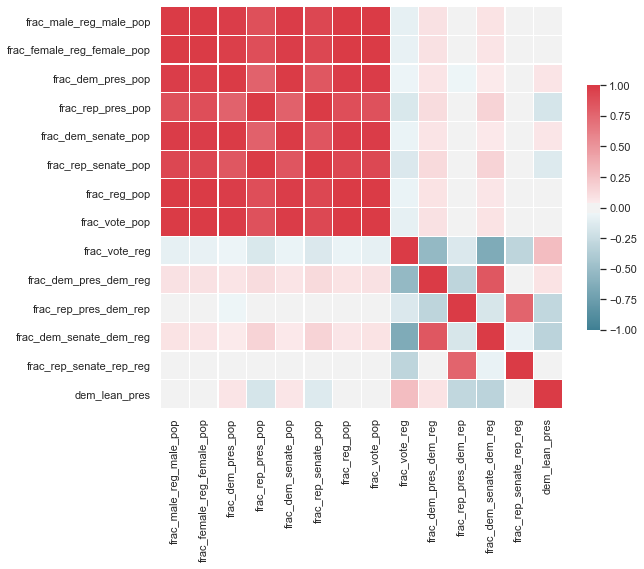

In [66]:
sub_data = corr_data.iloc[11:25, 11:25]
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(sub_data, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .5})

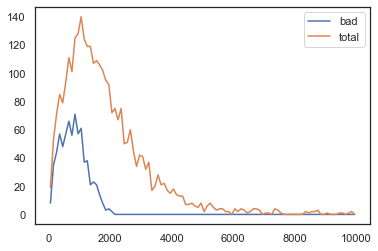

In [67]:
miss = []
step = 100
for x in range(50, 10000, step):
    miss.append((x,
                 len(precinct_data_2016[(precinct_data_2016.population < x)
                                        & (precinct_data_2016.population > x-step)]),
                 len(precinct_data_2016[(precinct_data_2016.population < x) 
                                        & (precinct_data_2016.population > x-step)
                                        & (precinct_data_2016['female rv_active'] > x/2)])))
x = [x for x, _, _ in miss]
total = [x for _, x, _ in miss]
bad = [x for _, _, x in miss]

plt.plot(x, bad, label='bad')
plt.plot(x, total, label='total')
plt.legend()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20989bd0>]],
      dtype=object)

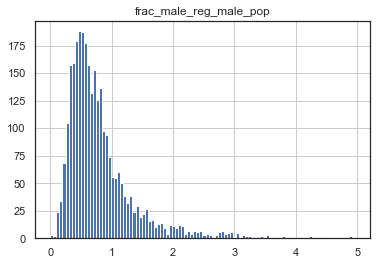

In [68]:
data[data.frac_male_reg_male_pop < 5].fillna(0).replace([np.inf, -np.inf], 0).hist(column='frac_male_reg_male_pop', bins=100)

## Results with area

In [ ]:
data2 = precinct_data_2016.copy()
data2["area"] = (precinct_data_2016['geometry'].to_crs({'init': 'epsg:3395'})
                                .map(lambda p: p.area / 10**6))
data2 = data2.drop(columns=['geometry'])
data2["area_rank"] = np.argsort(data2.area.values)

In [ ]:
precinct_data_2016.head()

In [ ]:
pres_votes = ['pres dem', 'pres grn', 'pres lib', 'pres rep', 'pres unf']
data2["sum_votes"] = precinct_data_2016[pres_votes].sum(axis=1)
data2["frac_dem"] = (precinct_data_2016['pres dem']/data2["sum_votes"])
data2["frac_rep"] = (precinct_data_2016['pres rep']/data2["sum_votes"])
data2["margin_dem_rep"] = (data2.frac_dem-data2.frac_rep)/(data2.frac_dem+data2.frac_rep)
data2.head()

In [ ]:
data2["frac_college"] = (precinct_data_2016[["male bachelors", "male masters", "male doctorate", 
                              "female bachelors", "female masters", "female doctorate"]].sum(axis=1) /
                        precinct_data_2016["population"])

In [ ]:
data2 = pd.DataFrame(data2)
alt.Chart(data2).mark_circle().encode(
    x='frac_college',
    y='margin_dem_rep',
    #color='Origin',
    #tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
)

In [ ]:
"_".join(list(('asa','asas')))

In [ ]:
chlorodata = gpd.GeoDataFrame(data.copy())
chlorodata["geometry"] = precinct_data_2016.geometry

scales = alt.selection_interval(bind='scales')
alt.Chart(chlorodata).mark_geoshape().encode(
    color='population:Q'
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)

In [ ]:
r = .05
n = 3000
t = (r * np.sqrt(n-2))/(np.sqrt(1-r**2))
print(r,t)

In [ ]:
list(range(0,100,10))